# Explore Exercises

In [1]:
# regular imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import math
import env

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

# Wrangling
from sklearn.model_selection import train_test_split, learning_curve

# Personal Imports
import acquire
import prepare

In [2]:
df = acquire.wrangle_zillow()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        76 non-null     float64
 1   heatingorsystemtypeid         33935 non-null  float64
 2   buildingclasstypeid           0 non-null      object 
 3   architecturalstyletypeid      70 non-null     float64
 4   airconditioningtypeid         13638 non-null  float64
 5   propertylandusetypeid         52441 non-null  float64
 6   id                            52441 non-null  int64  
 7   parcelid                      52441 non-null  int64  
 8   logerror                      52441 non-null  float64
 9   transactiondate               52441 non-null  object 
 10  id                            52441 non-null  int64  
 11  parcelid                      52441 non-null  int64  
 12  basementsqft                  47 non-null     float64
 13  b

In [3]:
df.head()

,typeconstructiontypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,propertylandusetypeid,id,parcelid,logerror,transactiondate,...,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,propertylandusedesc,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,typeconstructiondesc
0,NaN,NaN,None,NaN,NaN,261.00,0,14297519,0.03,2017-01-01,...,"11,013.72",None,NaN,"60,590,630,072,012.00",Single Family Residential,None,None,None,None,None
1,NaN,NaN,None,NaN,NaN,261.00,1,17052889,0.06,2017-01-01,...,"5,672.48",None,NaN,"61,110,010,023,006.00",Single Family Residential,None,None,None,None,None
2,NaN,NaN,None,NaN,NaN,261.00,2,14186244,0.01,2017-01-01,...,"6,488.30",None,NaN,"60,590,218,022,012.00",Single Family Residential,None,None,None,None,None
3,NaN,2.00,None,NaN,NaN,261.00,3,12177905,-0.10,2017-01-01,...,"1,777.51",None,NaN,"60,373,001,001,006.00",Single Family Residential,None,None,None,Central,None
4,NaN,2.00,None,NaN,1.00,261.00,6,12095076,-0.00,2017-01-01,...,"9,516.26",None,NaN,"60,374,608,001,014.00",Single Family Residential,Central,None,None,Central,None


In [4]:
# Potential function for removing properties other than single unit properties
def trim_bad_data_zillow(df):
    # If it's not single unit, it's not a single family home.
    df = df[~(df.unitcnt > 1)]
    # If the lot size is smaller than the finished square feet, it's probably bad data or not a single family home
    df = df[~(df.lotsizesquarefeet < df.calculatedfinishedsquarefeet)]
    # If the finished square feet is less than 500 it is likeley an apartment, or bad data
    df = df[~(df.calculatedfinishedsquarefeet < 500)]
    # If there are no bedrooms, likely a loft or bad data
    df = df[~(df.bedroomcnt < 1)]
    # Drop duplicate parcels
    df = df.drop_duplicates(subset='parcelid')
    return df


#Dropping columns with an inordinate number of nulls (rendering variable essentially useless)
def drop_bad_columns(df):
    df = df.drop(columns = [
        'typeconstructiontypeid',
        'heatingorsystemtypeid',
        'buildingclasstypeid',
        'architecturalstyletypeid',
        'airconditioningtypeid',
        'propertylandusetypeid',
        'basementsqft',
        'decktypeid',
        'finishedfloor1squarefeet',
        'finishedsquarefeet13',
        'finishedsquarefeet15',
        'finishedsquarefeet50',
        'finishedsquarefeet6',
        'fireplacecnt',
        'hashottuborspa',
        'poolsizesum',
        'pooltypeid10',
        'pooltypeid2',
        'pooltypeid7',
        'storytypeid',
        'yardbuildingsqft17',
        'yardbuildingsqft26',
        'numberofstories',
        'fireplaceflag',
        'taxdelinquencyflag',
        'taxdelinquencyyear',
        'architecturalstyledesc',
        'buildingclassdesc',
        'typeconstructiondesc',
        'buildingqualitytypeid',
        'propertyzoningdesc',
        'rawcensustractandblock',
        'regionidneighborhood',
        'threequarterbathnbr',
        'airconditioningdesc',
        'heatingorsystemdesc',
        'threequarterbathnbr'
        ],
        axis=1)

    return df
    
def drop_nulls(df):
    # Change all remaining null/nan values to 0 or the variable mean, depending on best use case
    df['poolcnt'] = df['poolcnt'].fillna(0)
    df['garagecarcnt'] = df['garagecarcnt'].fillna(0)
    df['garagetotalsqft'] = df['garagetotalsqft'].fillna(0)
    df['lotsizesquarefeet'] = df['lotsizesquarefeet'].fillna(value=df['lotsizesquarefeet'].mean())
    df['regionidcity'] = df['regionidcity'].fillna(0)
    df['unitcnt'] = df['unitcnt'].fillna(0)

    return df

def handle_nulls(df):    
    # We keep 99.41% of the data after dropping nulls
    # round(df.dropna().shape[0] / df.shape[0], 4) returned .9941
    df = df.dropna()
    return df


def optimize_types(df):
    # Convert some columns to integers for optimization
    # fips, yearbuilt, and bedrooms, taxvaluedollarcnt, and calculatedfinishedsquarefeet can be integers
    df["fips"] = df["fips"].astype(int)
    df["yearbuilt"] = df["yearbuilt"].astype(int)
    df["bedroomcnt"] = df["bedroomcnt"].astype(int)    
    df["taxvaluedollarcnt"] = df["taxvaluedollarcnt"].astype(int)
    df["calculatedfinishedsquarefeet"] = df["calculatedfinishedsquarefeet"].astype(int)
    return df


def handle_outliers(df):
    """Manually handle outliers that do not represent properties likely for 99% of buyers and zillow visitors"""
    df = df[df.bathroomcnt <= 6]
    
    df = df[df.bedroomcnt <= 6]

    df = df[df.taxvaluedollarcnt < 1_500_000]

    return df

def clean_variables(df):
    # Drop 'taxamount' column (variable is inconsistent based on time and location of collected value, could lead to poor analysis)
    # Rename columns and 'fips' values to reflect actual location (to solidify column as categorical variable)
    df = df.drop(columns = 'taxamount')
    df = df.rename(columns = {'bedroomcnt':'bedrooms', 
                              'bathroomcnt':'bathrooms', 
                              'calculatedfinishedsquarefeet':'sq_ft', 
                              'taxvaluedollarcnt':'home_value', 
                              'yearbuilt':'year_built', 
                              'fips':'location',
                              'fullbathcnt':'full_bathrooms',
                              'garagecarcnt':'garage_spaces',
                              'lotsizesquarefeet':'lot_sq_ft'
                             })
    df.location = df.location.replace(to_replace={6037:'LA County', 6059:'Orange County', 6111:'Ventura County'})

    return df 

def feature_engineering(df):
    # Bin `year_built` by decade
    df["decade_built"] = pd.cut(x=df["year_built"], bins=[1800, 1899, 1909, 1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009], labels=['1800s', '1900s', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '2000s'])
    # Convert categorical variable to numeric var
    df['county_encoded'] = df.location.map({'LA County': 0, 'Orange County': 1, 'Ventura County': 2})

    df = df.dropna()

    return df

# Split for Exploration

## 
# Train, Validate, Test Split Function: for exploration
def zillow_split_explore(df):
    '''
    This function performs split on telco data, stratifying on churn.
    Returns train, validate, and test dfs.
    '''
    train_validate, test = train_test_split(df, test_size=.2,
                                        random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3,
                                   random_state=123)
    return train, validate, test

### ------------------------------------------------------------------------

# Split for Modeling: X & Y dfs
def zillow_split_model(df):
    '''
    This function performs split on telco data, stratifying on churn.
    Returns both X and y train, validate, and test dfs
    '''
    
    train_validate, test = train_test_split(df, test_size=.2,
                                        random_state=123)
    train, validate = train_test_split(train_validate, test_size=.3,
                                   random_state=123)

    # Splitting train, validate, and test dfs on x and y
    x_train = train.drop(columns=['home_value'])
    x_validate = validate.drop(columns=['home_value'])
    x_test = test.drop(columns=['home_value'])

    y_train = train['home_value']
    y_validate = validate['home_value']
    y_test = test['home_value']
    
    return x_train, y_train, x_validate, y_validate, x_test, y_test


def prep_zillow(df):
    """
    Handles nulls
    optimizes or fixes data types
    handles outliers w/ manual logic
    clean variables via dropping columns and renaming features
    includes feature engineering 
    returns a clean dataframe
    Splits df into train, validate, test, and associated dfs on x and y 
    """

    df = drop_bad_columns(df)

    df = drop_nulls(df)

    df = handle_nulls(df)

    df = optimize_types(df)

    df = handle_outliers(df)

    df = clean_variables(df)

    df = feature_engineering(df)

    train, validate, test = zillow_split_explore(df)

    x_train, y_train, x_validate, y_validate, x_test, y_test = zillow_split_model(df)

    # df.to_csv("zillow.csv", index=False)

    return df, train, validate, test, x_train, y_train, x_validate, y_validate, x_test, y_test


In [5]:
df, train, validate, test, x_train, y_train, x_validate, y_validate, x_test, y_test = prepare.prep_zillow(df)

In [6]:
print(df.shape)
print(train.shape)
print(validate.shape)
print(test.shape)

(48267, 34)
(27029, 34)
(11584, 34)
(9654, 34)


In [7]:
df.head()

,id,parcelid,logerror,transactiondate,id,parcelid,bathrooms,bedrooms,calculatedbathnbr,sq_ft,...,unitcnt,year_built,structuretaxvaluedollarcnt,home_value,assessmentyear,landtaxvaluedollarcnt,censustractandblock,propertylandusedesc,decade_built,county_encoded
0,0,14297519,0.03,2017-01-01,1727539,14297519,3.50,4,3.50,3100,...,0.00,1998,"485,713.00",1023282,"2,016.00","537,569.00","60,590,630,072,012.00",Single Family Residential,90s,1
1,1,17052889,0.06,2017-01-01,1387261,17052889,1.00,2,1.00,1465,...,0.00,1967,"88,000.00",464000,"2,016.00","376,000.00","61,110,010,023,006.00",Single Family Residential,60s,2
2,2,14186244,0.01,2017-01-01,11677,14186244,2.00,3,2.00,1243,...,0.00,1962,"85,289.00",564778,"2,016.00","479,489.00","60,590,218,022,012.00",Single Family Residential,60s,1
3,3,12177905,-0.10,2017-01-01,2288172,12177905,3.00,4,3.00,2376,...,1.00,1970,"108,918.00",145143,"2,016.00","36,225.00","60,373,001,001,006.00",Single Family Residential,70s,0
4,6,12095076,-0.00,2017-01-01,781532,12095076,3.00,4,3.00,2962,...,1.00,1950,"276,684.00",773303,"2,016.00","496,619.00","60,374,608,001,014.00",Single Family Residential,50s,0


# Main Exploration

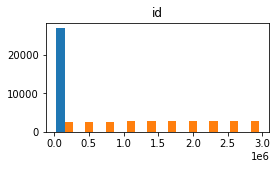

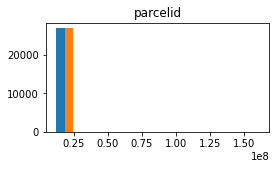

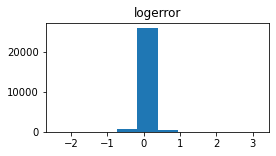

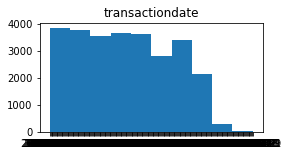

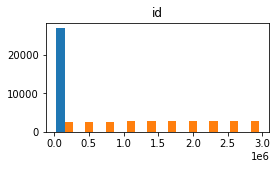

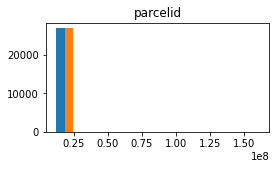

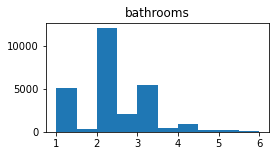

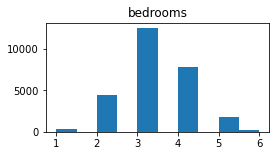

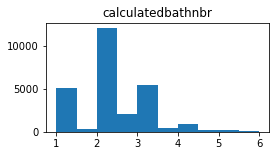

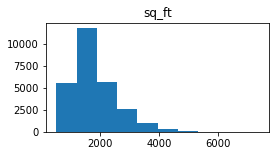

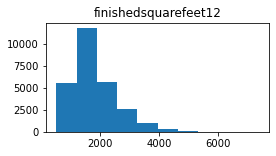

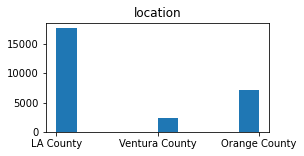

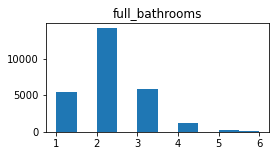

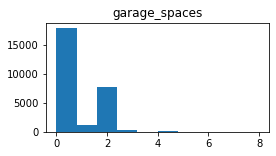

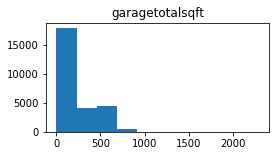

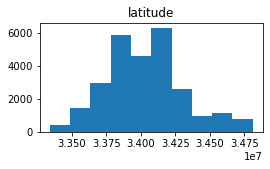

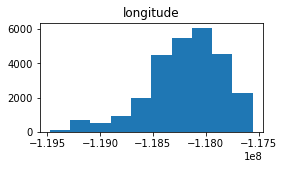

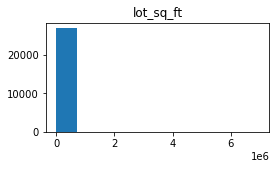

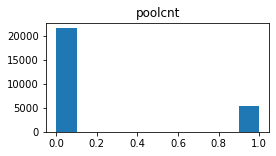

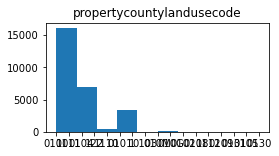

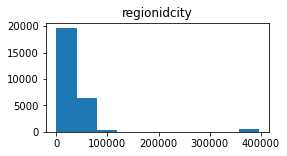

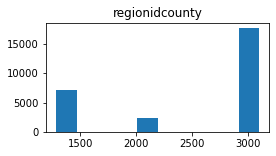

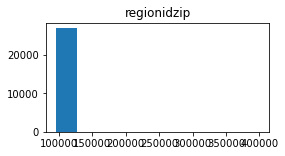

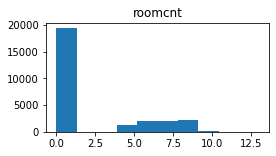

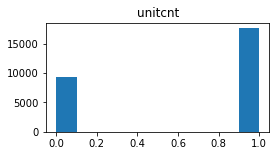

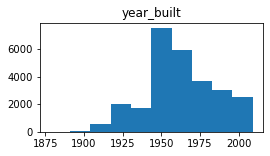

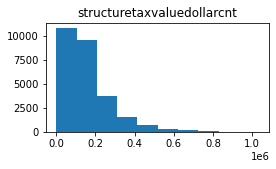

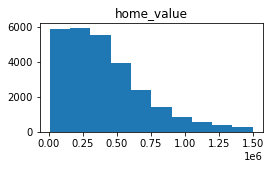

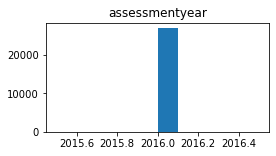

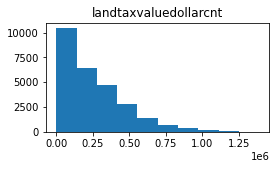

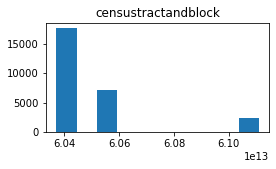

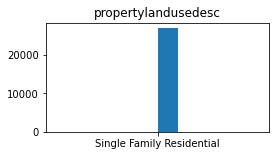

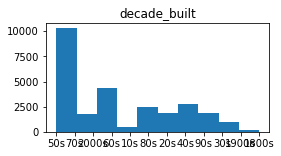

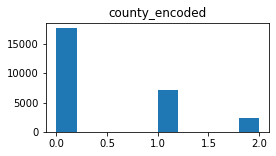

In [8]:
# loop for distribution of all variables, via histogram:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

# plotly 3d scatter
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width',
              color='species')
fig.update_layout(width=700, height=500)
# fig.update_layout(margin={"r":0,"t":0,"l":10,"b":0})
fig.show()